[View in Colaboratory](https://colab.research.google.com/github/YuliaZamriy/W207_Group_Project/blob/master/w207_openbarbell_lifter_segmentation.ipynb)

In [257]:
!git clone https://github.com/YuliaZamriy/W207_Group_Project.git

Cloning into 'W207_Group_Project'...
remote: Counting objects: 94, done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 94 (delta 46), reused 64 (delta 23), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [0]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import locale
import sys
import itertools
from locale import atof
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import metrics

from scipy.stats import mode

%matplotlib inline

In [9]:
# Jupyter viewing options
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))
# pd.set_option('display.max_columns', 500)

In [7]:
df = pd.read_csv("drive/Colab Notebooks/ob_data_w207_filtered.csv")
df.head(5)

,_id,deleted,endTime,exercise,initialStartTime,metric,removed_set,rpe,setID,setNumber,...,TimeRepWait,SlowAllow,Backlight,MinAllow,PeakAccel,_merge,rpe_num,weight_lbs,exercise_clean,exercise_clean2
0,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,...,0.0,130000.0,10000.0,150000.0,11.073610,both,7.5,192.90425,bench,bench
1,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,...,0.0,130000.0,10000.0,150000.0,0.714399,both,7.5,192.90425,bench,bench
2,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,...,0.0,130000.0,10000.0,150000.0,0.730685,both,7.5,192.90425,bench,bench
3,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,...,0.0,130000.0,10000.0,150000.0,0.923557,both,7.5,192.90425,bench,bench
4,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,...,0.0,130000.0,10000.0,150000.0,0.827607,both,7.5,192.90425,bench,bench


In [10]:
print("Data shape: {0}".format(df.shape))


Data shape: (292910, 45)


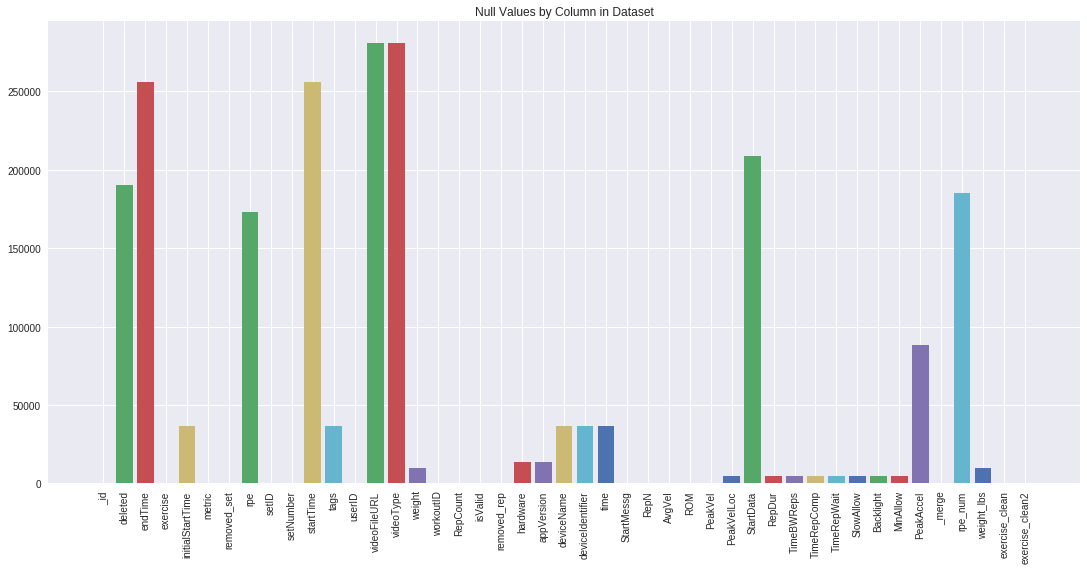

In [11]:
null_sums = df.isnull().sum()
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)
for i, null_col in enumerate(null_sums):
    plt.bar(i, null_col)

plt.title('Null Values by Column in Dataset')
plt.xticks(list(range(len(null_sums))), null_sums.index, rotation='vertical')
plt.show()

In [12]:
def get_label_distribution(label):
    i, j = np.unique(label, return_counts = True)
    return pd.DataFrame({"Exercise": i, "Row count": j})
        
        
get_label_distribution(df['exercise_clean'])

,Exercise,Row count
0,bench,94640
1,bench other,35117
2,deadlift,35966
3,deadlift other,7366
4,squat,77680
5,squat other,42141


### Potential features to consider for lifter segmentation:

 Lifting-related:
 
 - `rpe_num`: uses RPE or not
 - `weight_lbs`
 - `RepCount`: values start from 0 (counts of 1); higher repper vs. low
 - `ROM`
 - `PeakVel`
 - `PeakVelLoc`
 - `RepDur`
 - `PeakAccel`


User-related:

 - `initialStartTime` / `startTime` / `time`
 - `tags`: tagger or not
 - `workoutID`: number of unique workouts
 - `hardware`:  two values: (ios, android)
 - `deviceName`/`deviceIdentifier`:  how many devices is using
 
 
 ### Potential lifter identifiers:
 
 - Primary: `userID`
 - Secondary:`exercise_clean`


## EDA for Lifter Segmentation

In [0]:
def check_frequency(data, feature):
    counts = data[feature].value_counts()
    print(f"\n{feature} has {counts.shape[0]} unique values")
    print("Top 10 values are:")
    if counts.shape[0] > 10:
      print(counts[:10])
    else:
      print(counts)

In [89]:
ls_discrete_features = ['hardware', 'rpe_num', 'RepCount', 'tags', 'deviceName']
for v in ls_discrete_features:
  check_frequency(df, v)


hardware has 2 unique values
Top 10 values are:
ios        189386
android     89821
Name: hardware, dtype: int64

rpe_num has 45 unique values
Top 10 values are:
8.0     21131
7.0     21067
6.0     14131
5.5     12783
7.5      9561
9.0      8933
8.5      7849
6.5      6294
10.0     3354
Name: rpe_num, dtype: int64

RepCount has 115 unique values
Top 10 values are:
0.0     66760
1.0     61538
2.0     52633
3.0     35216
4.0     26591
5.0     15191
6.0      9561
7.0      7190
8.0      4404
9.0      3315
10.0     1801
Name: RepCount, dtype: int64

tags has 4097 unique values
Top 10 values are:
[]              148087
['Belt']          5788
['warmup']        3570
['belt']          2629
['Duffalo']       1836
['beltless']      1691
['Beltless']      1516
['warm up']       1422
['no belt ']      1405
['Speed']         1398
Name: tags, dtype: int64

deviceName has 343 unique values
Top 10 values are:
OB 3248    9059
OB 6666    6897
OB 2257    6748
OB 3434    6059
OB 3302    5812
OB 3162    56

In [93]:
def get_descr(data, features):
  data_descr = data[features].describe()
  pct_missing = pd.Series(100-np.around(data_descr.loc['count',]/data.shape[0]*100,2))
  pct_missing.name = 'pct_missing'
  pct_zero = pd.Series([round(100*sum(data[v] == 0)/data.shape[0],2) for v in features])
  pct_zero.name = 'pct_zeros'
  pct_zero.index = pct_missing.index
  data_descr = data_descr.append(pct_missing)
  data_descr = data_descr.append(pct_zero)
  return data_descr
  
ls_cont_features = ['rpe_num', 'RepCount', 'weight_lbs',  
                    'ROM', 'PeakVel', 'PeakVelLoc', 'RepDur', 'PeakAccel']

get_descr(df, ls_cont_features)

,rpe_num,RepCount,weight_lbs,ROM,PeakVel,PeakVelLoc,RepDur,PeakAccel
count,107928.000000,292910.000000,283142.000000,292910.000000,292910.000000,288513.000000,2.885130e+05,204717.000000
mean,7.330340,2.775013,235.271909,462.061456,0.771857,72.132299,1.102977e+06,15.439559
std,1.201296,4.143754,105.251502,157.312786,0.377337,20.038203,4.745798e+05,59.320897
min,5.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,6.500000,1.000000,165.000000,326.000000,0.483974,65.000000,7.656250e+05,3.307050
50%,7.000000,2.000000,225.000000,450.000000,0.718287,79.000000,1.030670e+06,6.186958
75%,8.000000,4.000000,300.000000,598.000000,0.976293,87.000000,1.363892e+06,12.775880
max,10.000000,114.000000,1000.000000,1761.000000,5.560000,99.000000,1.129953e+07,2686.953000
pct_missing,63.150000,0.000000,3.330000,0.000000,0.000000,1.500000,1.500000e+00,30.110000
pct_zeros,0.000000,22.790000,0.130000,0.000000,0.000000,0.010000,1.000000e-02,0.020000


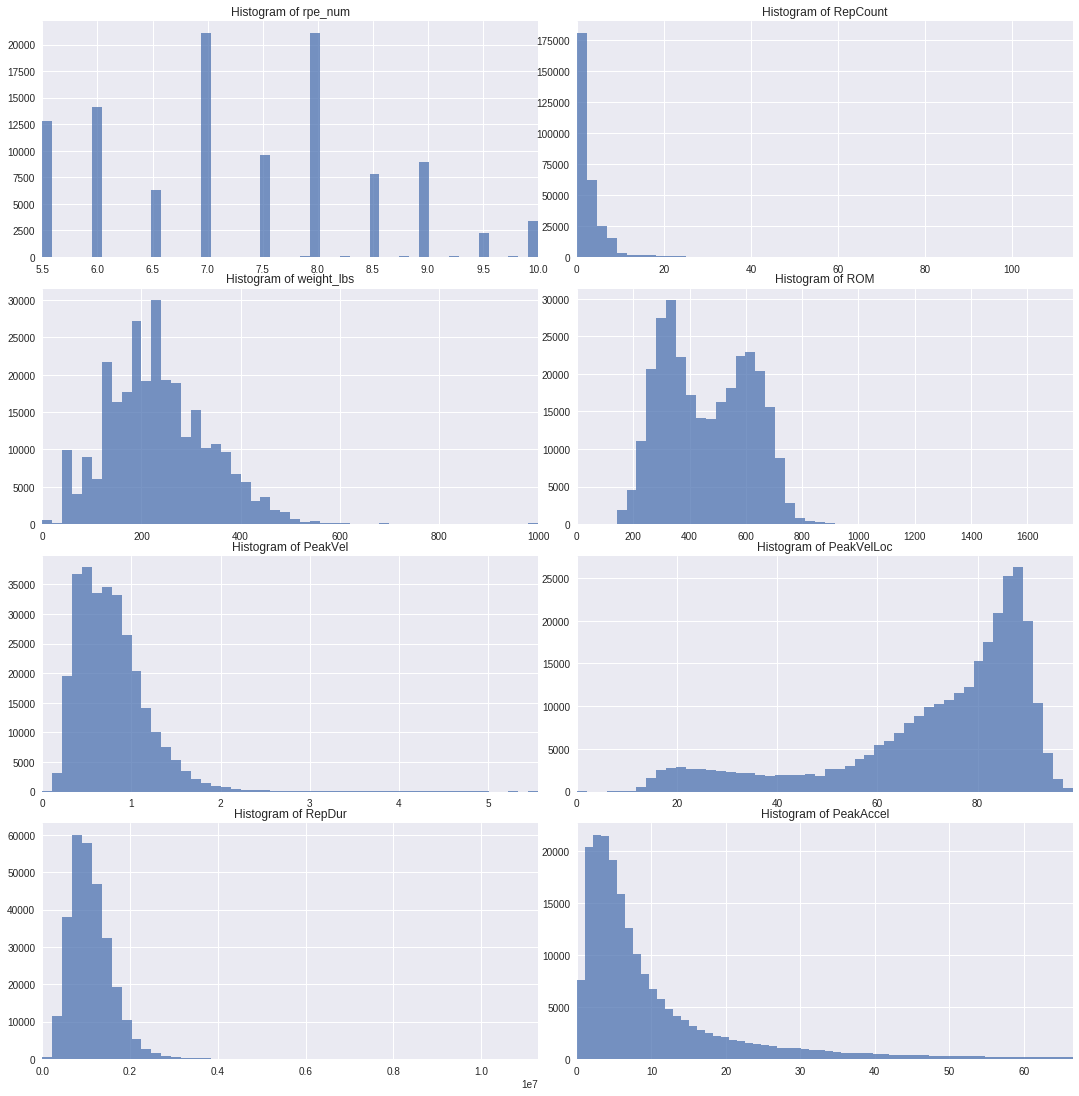

In [187]:
def plot_multi_hist(data, features):
  nrows = len(features)//2
  ncols = min(len(features), 2)
  fig, axs = plt.subplots(nrows, ncols, figsize=(15,15))
  fig.tight_layout()
  for ax, index in zip(axs.ravel(), range(len(features))):
    bins = 50
    adj = 10
    xmin = np.min(data[features[index]])
    xmax = np.max(data[features[index]])
    x99 = np.nanpercentile(data[features[index]], 99)
    if xmax/x99 > adj:
      xmax = x99/2
      bins *= adj*5
    ax.hist(data[features[index]].dropna(), bins, alpha=0.75)
    ax.set_title(f'Histogram of {features[index]}')
    ax.set_xlim([xmin, xmax])
    ax.grid(True)
  plt.show()
  
ls_cont_features = ['rpe_num', 'RepCount', 'weight_lbs',  
                    'ROM', 'PeakVel', 'PeakVelLoc', 'RepDur', 'PeakAccel']

plot_multi_hist(df, ls_cont_features)

## Figuring out lifter id

In [0]:
def feature_descr(feature):
  print(f"{feature.name} Summary:")
  print(feature.describe())
  
  print(f"\nLow occurrence for {feature.name}:")
  for i in range(1, 10):
    print(f"There are {sum(feature==i)} unique values with {i} observation(s)")
  
  print(f"\n{feature.name} Histogram:")
  xmin, xmax = np.min(feature), np.nanpercentile(feature, 99)
  plt.hist(feature, 100, facecolor = 'g', alpha = 0.75)
  plt.xlim([xmin, xmax])
  plt.show()

In [172]:
userID_count = df['userID'].value_counts()
userID_count.shape

(460,)

userID Summary:
count      460.000000
mean       636.760870
std       1257.673288
min          1.000000
25%         27.750000
50%        111.500000
75%        571.250000
max      10568.000000
Name: userID, dtype: float64

Low occurrence for userID:
There are 2 unique values with 1 observation(s)
There are 4 unique values with 2 observation(s)
There are 8 unique values with 3 observation(s)
There are 6 unique values with 4 observation(s)
There are 6 unique values with 5 observation(s)
There are 6 unique values with 6 observation(s)
There are 5 unique values with 7 observation(s)
There are 11 unique values with 8 observation(s)
There are 2 unique values with 9 observation(s)

userID Histogram:


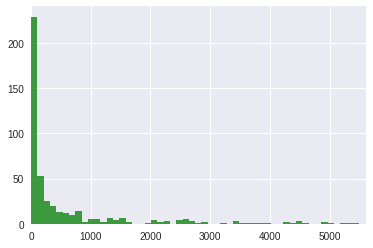

In [236]:
feature_descr(userID_count)

In [0]:
df_grouped_wourkout = df.groupby(['userID', 'workoutID'])
df_grouped_wourkout = df_grouped.size()
df_grouped_wourkout.name = 'userID-workoutID count'

userID-workoutID count Summary:
count    11034.000000
mean        26.546130
std         21.903629
min          1.000000
25%         10.000000
50%         22.000000
75%         36.000000
max        345.000000
Name: userID-workoutID count, dtype: float64

Low occurrence for userID-workoutID count:
There are 261 unique values with 1 observation(s)
There are 314 unique values with 2 observation(s)
There are 430 unique values with 3 observation(s)
There are 302 unique values with 4 observation(s)
There are 236 unique values with 5 observation(s)
There are 302 unique values with 6 observation(s)
There are 172 unique values with 7 observation(s)
There are 228 unique values with 8 observation(s)
There are 323 unique values with 9 observation(s)

userID-workoutID count Histogram:


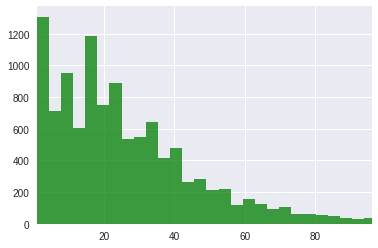

In [252]:
feature_descr(df_grouped_wourkout)

In [241]:
df_grouped_count.loc[df_grouped_count == max(df_grouped_count)]

userID                    workoutID                           
5aa35456880e87b3f32ddf7c  c1d046a3-bf4e-4ba8-a43a-2568a3b21620    345
Name: userID-workoutID count, dtype: int64

In [249]:
# this is account used for S&S internal study
# we might need to exclude it (multiple people)
df_study = df.loc[df['userID'] == '5aa35456880e87b3f32ddf7c']
df_study.shape

(3506, 45)

In [247]:
df_grouped_count.sort_values(ascending=False)[:10]

userID                    workoutID                           
5aa35456880e87b3f32ddf7c  c1d046a3-bf4e-4ba8-a43a-2568a3b21620    345
                          7464e24b-25af-4435-a29e-6735cf838dd4    305
                          870ca10a-1f71-4cbf-a3f8-6ef0f0cc56c1    281
                          21b51e5a-6a80-48d8-827b-b2309f4cd405    201
5a43c264fd4ef00da9b8ccce  3388ac48-1f31-46c1-88db-d82b72209a01    184
5a15b00e05cbc9b8ef26ac59  4d2ad298-337d-46bb-bd46-49f45d42158e    183
59debbdd05cbc9b8ef26ac1c  dbc82f2e-0401-43c6-9c9a-afc52434f724    176
5aa35456880e87b3f32ddf7c  908fe3e3-34c9-4c2f-8ae4-7d22354e2b9b    175
589d473d6ca711fcd8cb7af9  93a67da5-12c4-42d1-a067-ca77e04af8ab    174
5a43c264fd4ef00da9b8ccce  426232d3-7874-4c44-9a5a-6e9b860bbf1c    151
Name: userID-workoutID count, dtype: int64

## Grouping Dataset

In [0]:
df_clean = df.loc[df['exercise_clean'].isin(["squat", "bench", "deadlift"])]
df_grouped = df_clean.groupby(['userID', 'exercise_clean'])

userID Summary:
count      460.000000
mean       636.760870
std       1257.673288
min          1.000000
25%         27.750000
50%        111.500000
75%        571.250000
max      10568.000000
Name: userID, dtype: float64

Low occurrence for userID:
There are 2 unique values with 1 observation(s)
There are 4 unique values with 2 observation(s)
There are 8 unique values with 3 observation(s)
There are 6 unique values with 4 observation(s)
There are 6 unique values with 5 observation(s)
There are 6 unique values with 6 observation(s)
There are 5 unique values with 7 observation(s)
There are 11 unique values with 8 observation(s)
There are 2 unique values with 9 observation(s)

userID Histogram:


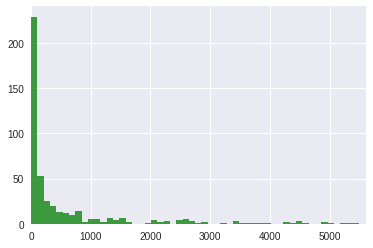

In [254]:
df_grouped.s